# User; Non-User; Light User

In [41]:
import pandas as pd
df_4 = pd.read_csv('df_clean.csv')
df_4.head()

,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS,Gender,Age_Binary,Education_Level,Europe_vs_Rest,Drug_Category_Code
0,-0.679435,1.943848,1.441121,0.762842,-0.142741,-0.752913,-0.221197,1,0,1,1,0
1,-0.468029,0.807218,-0.850379,-1.625666,-1.016636,-1.453411,0.419536,1,1,0,1,2
2,-0.148987,-0.808426,-0.019129,0.591826,0.586726,-1.453411,-1.223036,0,0,1,1,1
3,0.736985,-1.637866,-0.453265,-0.302804,1.309747,-0.235174,-0.221197,0,1,1,1,2
4,-0.679435,-0.301268,-1.561014,2.045171,1.635314,-1.453411,-1.604778,0,1,0,0,2


In [42]:
df_4['Drug_Category_Code'] = df_4['Drug_Category_Code'].replace(1, 0)
df_4['Drug_Category_Code'].value_counts()
new_mapping = {0: 0, 2: 2, 3: 1}
df_4['Drug_Category_Code_New'] = df_4['Drug_Category_Code'].replace(new_mapping)

# Now, check the new value counts
df_4['Drug_Category_Code_New'].value_counts()
# 0 - all users ; 1 - non-users ; 2 - light users

Drug_Category_Code_New
0    951
1    523
2    323
Name: count, dtype: int64

In [43]:
df_ml = df_4.copy()
df_ml.drop(columns='Drug_Category_Code', inplace=True)

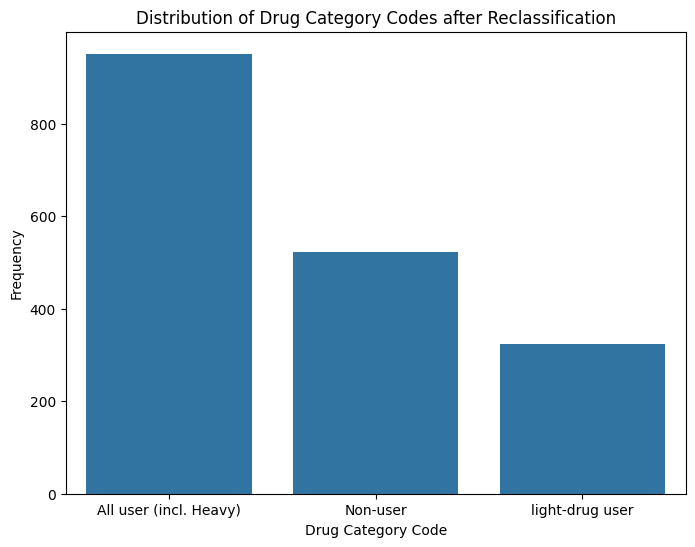

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
# Bar plot for the target variable distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Drug_Category_Code_New', data=df_4)
plt.title('Distribution of Drug Category Codes after Reclassification')
plt.xlabel('Drug Category Code')
plt.ylabel('Frequency')
# Since you now have only three categories, adjust the ticks and labels accordingly
plt.xticks(ticks=[0, 1, 2], labels=['All user (incl. Heavy)', 'Non-user', 'light-drug user'])
plt.show()

In [45]:
from umap import UMAP

X = df_ml.drop(columns=['Drug_Category_Code_New'])
#y = df_ml['Drug_Category_Code_New']
y = df_ml['Drug_Category_Code_New'].map(int)

dimred = UMAP()
X_red = dimred.fit_transform(X)
X_red

array([[6.769192 , 7.2171445],
       [6.185448 , 3.9477947],
       [7.7638254, 3.6211865],
       ...,
       [3.518035 , 3.9496062],
       [1.918509 , 5.097269 ],
       [5.555498 , 8.203971 ]], dtype=float32)

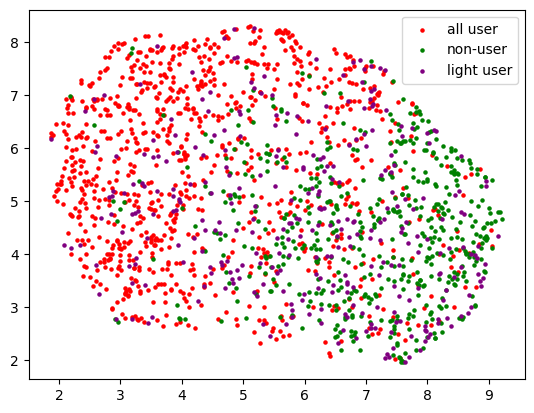

In [46]:
import matplotlib.pyplot as plt

colors = ['red', 'green', 'purple']
labels = ['all user', 'non-user', 'light user']

for i, (color, label) in enumerate(zip(colors, labels)):
    mask = y == i
    plt.scatter(X_red[mask,0], X_red[mask,1], c=color, label=label, s=5)

plt.legend()

here, using UMAP (dimensionality reduction technique) we can see that division between all-users and non-users can be done that purple dots are all over the place and there is hard to see any pattern. 
It can be due to that all-users: users of light and heavy drugs they can share similar features as people that only do shrooms or weed. 

Perhaps the division of drugs could be done in a diffrent way: party-drug; prescription drugs etc

In [47]:
X = df_ml.drop(columns=['Drug_Category_Code_New'])
#y = df_ml['Drug_Category_Code_New']
y = pd.get_dummies(df_ml['Drug_Category_Code_New']).map(int)
y.head()

,0,1,2
0,1,0,0
1,0,0,1
2,1,0,0
3,0,0,1
4,0,0,1


In [48]:
from sklearn.model_selection import train_test_split
# Split data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=40, stratify=y)  # 20% for testing


In [49]:
from sklearn.utils import compute_class_weight
import numpy as np
# Re-encoding y for class weights calculation (required format for compute_class_weight)
y_labels = df_ml['Drug_Category_Code_New']

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_labels), y=y_labels)
class_weights_dict = dict(enumerate(class_weights))

print(class_weights_dict)  # This will show you the computed class weights

{0: 0.629863301787592, 1: 1.1453154875717018, 2: 1.8544891640866874}


In [57]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
np.random.seed(0)
tf.random.set_seed(0)
# Define your model architecture
from tensorflow.keras.layers import LeakyReLU

model = Sequential([
    Dense(48, input_dim=X_train.shape[1]),
    LeakyReLU(alpha=0.01),
    Dense(32),
    LeakyReLU(alpha=0.01),
    Dense(16),
    LeakyReLU(alpha=0.01),
    Dense(y_train.shape[1], activation='softmax')  # Softmax is typically appropriate for the output layer
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['f1_score'])

# Train the model with class weights
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Include early stopping in the model's fit method
history = model.fit(
    X_train, y_train, 
    epochs=200, 
    batch_size=5, 
    verbose=1, 
    validation_split=0.2, 
    class_weight=class_weights_dict, 
    callbacks=[early_stopping]
)

Epoch 1/200


c:\Users\maxsz\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\maxsz\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - f1_score: 0.4264 - loss: 1.0018 - val_f1_score: 0.5291 - val_loss: 0.8573
Epoch 2/200
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - f1_score: 0.5881 - loss: 0.8271 - val_f1_score: 0.5685 - val_loss: 0.8270
Epoch 3/200
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - f1_score: 0.6169 - loss: 0.7953 - val_f1_score: 0.5618 - val_loss: 0.8290
Epoch 4/200
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - f1_score: 0.6167 - loss: 0.7794 - val_f1_score: 0.5655 - val_loss: 0.8280
Epoch 5/200
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - f1_score: 0.6368 - loss: 0.7666 - val_f1_score: 0.5684 - val_loss: 0.8257
Epoch 6/200
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - f1_score: 0.6357 - loss: 0.7546 - val_f1_score: 0.5808 - val_loss: 0.8319
Epoch 7/200
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - f1_score: 0.6533 - loss: 0.7412 - val_f1_score: 0.5929 - val_loss: 0.8350
Epoch 8/200
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - f1_score: 0.6665 - loss: 0.7294 - val_f1_score: 0.5897

Not the best results using the NN technique

In [58]:
from sklearn.metrics import classification_report
from tensorflow.keras.metrics import Recall

# Predicting on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification report
class_report = classification_report(y_true_classes, y_pred_classes)
print("Classification Report:\n", class_report)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.79      0.83       190
           1       0.66      0.72      0.69       105
           2       0.39      0.43      0.41        65

    accuracy                           0.71       360
   macro avg       0.64      0.65      0.64       360
weighted avg       0.72      0.71      0.71       360



In [59]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_true=y_true_classes, y_pred=y_pred_classes)

Confusion Matrix diff threshold:
[[151  20  19]
 [  5  76  24]
 [ 18  19  28]]


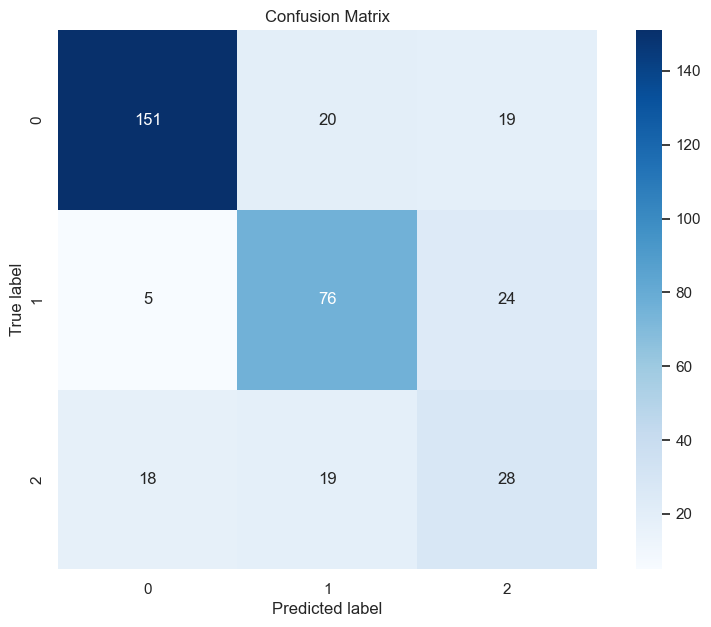

In [60]:
print("Confusion Matrix diff threshold:")
print(conf_matrix)

sns.set(style="whitegrid")

# Create the heatmap for the confusion matrix
plt.figure(figsize=(10, 7))  # Adjust the figure size as needed
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', square=True)
            # xticklabels=['all user', 'non user', 'light user'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
